<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
#!pip list

In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
#!pip3 install torchinfo
from torchinfo import summary

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [8]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [9]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 5985


In [10]:
input_sentences[10], output_sentences[10], output_sentences_inputs[10]

('i love disney movies ',
 'what is your favorite  <eos>',
 '<sos> what is your favorite ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [11]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [12]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1783
Sentencia de entrada más larga: 9


In [13]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1794
Sentencia de salida más larga: 10


In [37]:
# Limitar el tamaño de las sentencias de entrada y salida
max_input_len = 10  # O el valor que consideres adecuado
max_out_len = 10    # O el valor que consideres adecuado

from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 5985
encoder_input_sequences shape: (5985, 10)
decoder_input_sequences shape: (5985, 10)


In [38]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(5985, 10, 1795)

In [39]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 10
decoder_input_size: 10
Output dim 1795


In [40]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 4788
Tamaño del conjunto de validacion: 1197


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [41]:
import os
import gdown

# Descargar los embeddings de FastText desde Google Drive
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [42]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [43]:
model_embeddings = FasttextEmbeddings()

In [44]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [45]:
# Dimensión de los embeddings de la secuencia
embedding_matrix.shape

(1783, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [63]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 10, 1795]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 10, 300]              (534,900)
│    └─LSTM: 2-2                         [1, 10, 128]              220,160
├─Decoder: 1-2                           [1, 1795]                 --
│    └─Embedding: 2-3                    [1, 1, 300]               538,500
│    └─LSTM: 2-4                         [1, 1, 128]               220,160
│    └─Linear: 2-5                       [1, 1795]                 231,555
│    └─Softmax: 2-6                      [1, 1795]                 --
├─Decoder: 1-3                           [1, 1795]                 (recursive)
│    └─Embedding: 2-7                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-8                         [1, 1, 128]               (recursive)
│    └─Linear: 2-9             

In [47]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y almacenando los valores para imprimirlos y graficarlos
        valid_iterator = iter(valid_loader)
        valid_encoder_input, valid_decoder_input, valid_target = next(valid_iterator)
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))
        
        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
            epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history


In [86]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 67.217 - Train accuracy 0.772 - Valid Loss 67.689 - Valid accuracy 0.722
Epoch: 2/200 - Train loss 67.216 - Train accuracy 0.772 - Valid Loss 67.668 - Valid accuracy 0.731
Epoch: 3/200 - Train loss 67.211 - Train accuracy 0.773 - Valid Loss 67.631 - Valid accuracy 0.731
Epoch: 4/200 - Train loss 67.213 - Train accuracy 0.773 - Valid Loss 67.647 - Valid accuracy 0.731
Epoch: 5/200 - Train loss 67.207 - Train accuracy 0.773 - Valid Loss 67.669 - Valid accuracy 0.728
Epoch: 6/200 - Train loss 67.208 - Train accuracy 0.773 - Valid Loss 67.647 - Valid accuracy 0.728
Epoch: 7/200 - Train loss 67.204 - Train accuracy 0.774 - Valid Loss 67.654 - Valid accuracy 0.728
Epoch: 8/200 - Train loss 67.200 - Train accuracy 0.774 - Valid Loss 67.683 - Valid accuracy 0.728
Epoch: 9/200 - Train loss 67.197 - Train accuracy 0.774 - Valid Loss 67.709 - Valid accuracy 0.725
Epoch: 10/200 - Train loss 67.201 - Train accuracy 0.774 - Valid Loss 67.691 - Valid accuracy 0.725
Epoch: 11

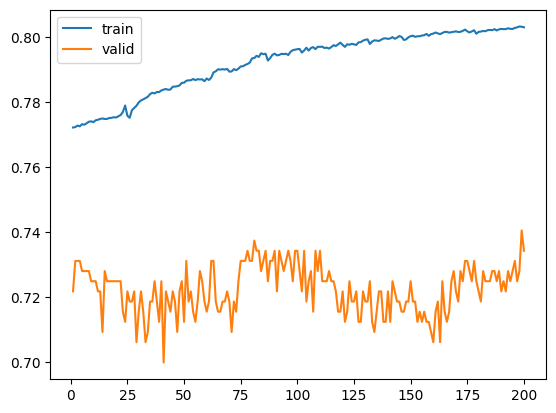

In [87]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [93]:
# Crear los conversores de índice a palabra:
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

import torch
import numpy as np

# Asegúrate de que el modelo esté en modo de evaluación
model.eval()

def translate_sentence(input_seq):
    # Se transforma la secuencia de entrada a los estados "h" y "c" de la LSTM para enviar al decoder
    prev_state = model.encoder(input_seq.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu().numpy())

        # Si es "end of sentence <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx in idx2word_target:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la última predicción
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

# Prueba con una oración de entrada
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test_tensor)
print('Response:', translation)

for n in range(1,5):
    # Prueba con una secuencia aleatoria del conjunto de datos
    i = np.random.choice(len(input_sentences))
    input_seq = encoder_input_sequences[i:i+1]
    encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
    translation = translate_sentence(encoder_sequence_test_tensor)
    print('-')
    print('Input:', input_sentences[i])
    print('Response:', translation)

Input: My mother say hi.
Response: i am a vegan
-
Input: cool 
Response: i am a vegan
-
Input: oh how old are you 
Response: i am fine
-
Input: i love to read
Response: what is your favorite
-
Input: do you have any hobbies 
Response: i am a student


### Conclusiones

El modelo no responde correctamente (como era esperado) pero genera diferentes respuestas en función del conjunto de entrada que tiene una presumible coherencia en algunos casos como relacionar "hobbies" con "student", "are you" con "fine" o "i love to read" con "what is your favorite", siendo las útlimas un par de frases coherentes en una conversación.
Se utilizó un learning rate de 0.01 y como optimizador RMS, ya que con Adam no logré buenos resultados.